# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
import time
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train__2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train__5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(25192, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]
    
    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

    
preprocess.x_train.std()

0.97509982675167528

In [6]:
import tensorflow as tf
from tensorflow.contrib.legacy_seq2seq.python.ops.seq2seq import basic_rnn_seq2seq
from tensorflow.contrib.rnn import RNNCell, LSTMCell, MultiRNNCell


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 122
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x_input = tf.placeholder("float", shape=[None, 1, input_dim])
            self.y_input_ = tf.placeholder("float", shape=[None, 1, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
            self.x_list = tf.unstack(self.x_input, axis= 1)
            self.y_list_ = tf.unstack(self.y_input_, axis = 1)
            self.y_ = self.y_list_[0]
            
            #GO = tf.fill((tf.shape(self.x)[0], 1), 0.5)
            
            #y_with_GO = tf.stack([self.y_, GO])
            
        with tf.variable_scope("lstm"):
            multi_cell = MultiRNNCell([LSTMCell(input_dim) for i in range(hidden_layers)] )
            
            self.y, states = basic_rnn_seq2seq(self.x_list, self.y_list_, multi_cell)
            #self.y = tf.slice(self.y, [0, 0], [-1,2])
            
            #self.out = tf.squeeze(self.y)
            
            #self.y = tf.layers.dense(self.y[0], classes, activation = None)
            
            self.y = tf.slice(self.y[0], [0, 0], [-1,2])
            
        with tf.variable_scope("Loss"):
            
            self.regularized_loss = tf.losses.mean_squared_error(self.y_, self.y)
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

batch_iterations = 200

x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
for i in batch_indices:
    print(x_train[i,np.newaxis,:])
    print(y_train[i,np.newaxis,:])

In [8]:
import collections

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'test_score_20', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_lstm_nsl_kdd-orig-/hidden layers_{}_features count_{}".format(h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            
            accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x_input: preprocess.x_test[:,np.newaxis,:], 
                                                                             net.y_input_: preprocess.y_test[:,np.newaxis,:], 
                                                                             net.keep_prob:1})
            
            print("Initial Accuracy, before training: {}".format(accuracy))
            
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        _, train_loss = sess.run([net.train_op, net.regularized_loss], #net.summary_op
                                                              feed_dict={net.x_input: x_train[i,np.newaxis,:], 
                                                                         net.y_input_: y_train[i,np.newaxis,:], 
                                                                         net.keep_prob:1, net.lr:lr})
                        #summary_writer_train.add_summary(summary_str, epoch)
                        if(train_loss > 1e9):
                            print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))


                    valid_accuracy,valid_loss = sess.run([net.tf_accuracy, net.regularized_loss], #net.summary_op 
                                                          feed_dict={net.x_input: x_valid[:,np.newaxis,:], 
                                                                     net.y_input_: y_valid[:,np.newaxis,:], 
                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)



                    accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x_input: preprocess.x_test[:,np.newaxis,:], 
                                                                             net.y_input_: preprocess.y_test[:,np.newaxis,:], 
                                                                             net.keep_prob:1, net.lr:lr})
                    
                    accuracy_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x_input: preprocess.x_test_[:,np.newaxis,:], 
                                                                             net.y_input_: preprocess.y_test_[:,np.newaxis,:], 
                                                                             net.keep_prob:1, net.lr:lr})

                    print("Step {} | Training Loss: {:.6f} | Train Accuracy: {:.6f} | Test Accuracy: {:.6f}, {:.6f}".format(epoch, train_loss, valid_accuracy, accuracy, accuracy_))

                    if accuracy > Train.best_acc_global:
                                Train.best_acc_global = accuracy
                                Train.pred_value = pred_value
                                Train.actual_value = actual_value
                                Train.pred_value_ = pred_value_
                                Train.actual_value_ = actual_value_
                                Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                        Train.best_acc = accuracy
                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_lstm_nsl_kdd-orig-/hidden layers_{}_features count_{}/model"
                                       .format(h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format((epochs+1)* (c+1),f,h):
                                                  (curr_pred, 
                                                   Train.result((epochs+1)*(c+1), f, h,valid_accuracy, accuracy, accuracy_, time.perf_counter() - start_time))})



            

In [9]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():

        global df_results
        global past_scores
        
        Train.predictions = {}
        Train.results = []
        
        features_arr = [1] #[4, 8, 16, 32]
        hidden_layers_arr = [1, 3, 5]

        epochs = [5]
        lrs = [1e-2, 1e-2/2, 1e-2/4]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
            
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)
        temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/tf_lstm_nsl_kdd-orig_all-.pkl'):
            past_scores = temp
        else:
            past_scores = pd.read_pickle("dataset/tf_lstm_nsl_kdd-orig_all-.pkl")

        past_scores.append(temp).to_pickle("dataset/tf_lstm_nsl_kdd-orig_all-.pkl")


In [10]:
%%timeit -r 10

Hyperparameters.start_training()

Current Layer Attributes - epochs:5 hidden layers:1 features count:1
Initial Accuracy, before training: 0.32261356711387634
Step 1 | Training Loss: 0.016385 | Train Accuracy: 0.991270 | Test Accuracy: 0.773776, 0.569958
Step 2 | Training Loss: 0.003571 | Train Accuracy: 0.998810 | Test Accuracy: 0.840268, 0.696118
Step 3 | Training Loss: 0.001502 | Train Accuracy: 1.000000 | Test Accuracy: 0.863112, 0.739578
Step 4 | Training Loss: 0.004050 | Train Accuracy: 1.000000 | Test Accuracy: 0.881388, 0.774346
Step 5 | Training Loss: 0.001231 | Train Accuracy: 1.000000 | Test Accuracy: 0.894074, 0.798481
Step 1 | Training Loss: 0.002052 | Train Accuracy: 0.999603 | Test Accuracy: 0.891324, 0.793249
Step 2 | Training Loss: 0.001239 | Train Accuracy: 0.999603 | Test Accuracy: 0.896913, 0.803882
Step 3 | Training Loss: 0.000982 | Train Accuracy: 0.999603 | Test Accuracy: 0.895937, 0.802025
Step 4 | Training Loss: 0.001035 | Train Accuracy: 1.000000 | Test Accuracy: 0.897268, 0.804557
Step 5 | Tra

Step 4 | Training Loss: 0.038528 | Train Accuracy: 0.959921 | Test Accuracy: 0.741927, 0.510464
Step 5 | Training Loss: 0.031406 | Train Accuracy: 0.976984 | Test Accuracy: 0.757275, 0.540084
Step 1 | Training Loss: 0.024576 | Train Accuracy: 0.977778 | Test Accuracy: 0.756388, 0.538143
Step 2 | Training Loss: 0.016818 | Train Accuracy: 0.977778 | Test Accuracy: 0.757541, 0.540338
Step 3 | Training Loss: 0.020849 | Train Accuracy: 0.979762 | Test Accuracy: 0.758295, 0.540675
Step 4 | Training Loss: 0.026334 | Train Accuracy: 0.973413 | Test Accuracy: 0.756299, 0.537637
Step 5 | Training Loss: 0.018600 | Train Accuracy: 0.978571 | Test Accuracy: 0.758472, 0.543038
Step 1 | Training Loss: 0.004535 | Train Accuracy: 0.978968 | Test Accuracy: 0.758295, 0.542363
Step 2 | Training Loss: 0.028874 | Train Accuracy: 0.983730 | Test Accuracy: 0.763219, 0.550127
Step 3 | Training Loss: 0.010361 | Train Accuracy: 0.982143 | Test Accuracy: 0.762287, 0.549198
Step 4 | Training Loss: 0.006997 | Train

Step 3 | Training Loss: 0.000649 | Train Accuracy: 1.000000 | Test Accuracy: 0.994455, 0.989451
Step 4 | Training Loss: 0.000649 | Train Accuracy: 1.000000 | Test Accuracy: 0.994455, 0.989451
Step 5 | Training Loss: 0.000648 | Train Accuracy: 1.000000 | Test Accuracy: 0.994455, 0.989451
Step 1 | Training Loss: 0.000648 | Train Accuracy: 1.000000 | Test Accuracy: 0.994455, 0.989451
Step 2 | Training Loss: 0.000648 | Train Accuracy: 1.000000 | Test Accuracy: 0.994455, 0.989451
Step 3 | Training Loss: 0.000648 | Train Accuracy: 1.000000 | Test Accuracy: 0.994411, 0.989367
Step 4 | Training Loss: 0.000648 | Train Accuracy: 1.000000 | Test Accuracy: 0.994411, 0.989367
Step 5 | Training Loss: 0.000648 | Train Accuracy: 1.000000 | Test Accuracy: 0.994411, 0.989367
Current Layer Attributes - epochs:5 hidden layers:5 features count:1
Initial Accuracy, before training: 0.2686302363872528
Step 1 | Training Loss: 0.001330 | Train Accuracy: 0.964683 | Test Accuracy: 0.770360, 0.564641
Step 2 | Trai

Step 2 | Training Loss: 0.001961 | Train Accuracy: 1.000000 | Test Accuracy: 0.890658, 0.791983
Step 3 | Training Loss: 0.001042 | Train Accuracy: 1.000000 | Test Accuracy: 0.896824, 0.803713
Step 4 | Training Loss: 0.001836 | Train Accuracy: 1.000000 | Test Accuracy: 0.894828, 0.799916
Step 5 | Training Loss: 0.001475 | Train Accuracy: 1.000000 | Test Accuracy: 0.895094, 0.800422
Current Layer Attributes - epochs:5 hidden layers:3 features count:1
Initial Accuracy, before training: 0.5106014609336853
Step 1 | Training Loss: 0.042527 | Train Accuracy: 0.972222 | Test Accuracy: 0.746274, 0.520169
Step 2 | Training Loss: 0.000728 | Train Accuracy: 0.999603 | Test Accuracy: 0.999601, 0.999241
Step 3 | Training Loss: 0.000664 | Train Accuracy: 1.000000 | Test Accuracy: 0.999956, 0.999916
Step 4 | Training Loss: 0.000669 | Train Accuracy: 1.000000 | Test Accuracy: 0.999956, 0.999916
Step 5 | Training Loss: 0.000649 | Train Accuracy: 1.000000 | Test Accuracy: 0.999911, 0.999831
Step 1 | Trai

Initial Accuracy, before training: 0.7685858607292175
Step 1 | Training Loss: 0.008558 | Train Accuracy: 0.995238 | Test Accuracy: 0.817113, 0.652067
Step 2 | Training Loss: 0.004708 | Train Accuracy: 0.999603 | Test Accuracy: 0.825364, 0.667848
Step 3 | Training Loss: 0.001624 | Train Accuracy: 0.999603 | Test Accuracy: 0.849760, 0.714177
Step 4 | Training Loss: 0.001387 | Train Accuracy: 0.999603 | Test Accuracy: 0.849450, 0.713587
Step 5 | Training Loss: 0.001592 | Train Accuracy: 1.000000 | Test Accuracy: 0.865596, 0.744304
Step 1 | Training Loss: 0.006249 | Train Accuracy: 1.000000 | Test Accuracy: 0.894606, 0.799494
Step 2 | Training Loss: 0.001059 | Train Accuracy: 1.000000 | Test Accuracy: 0.896026, 0.802194
Step 3 | Training Loss: 0.001549 | Train Accuracy: 1.000000 | Test Accuracy: 0.897933, 0.805823
Step 4 | Training Loss: 0.001581 | Train Accuracy: 1.000000 | Test Accuracy: 0.889505, 0.789789
Step 5 | Training Loss: 0.001192 | Train Accuracy: 1.000000 | Test Accuracy: 0.887

Step 5 | Training Loss: 0.005423 | Train Accuracy: 0.980952 | Test Accuracy: 0.772179, 0.567848
Step 1 | Training Loss: 0.024905 | Train Accuracy: 0.980159 | Test Accuracy: 0.766501, 0.556878
Step 2 | Training Loss: 0.000680 | Train Accuracy: 0.984127 | Test Accuracy: 0.773199, 0.568523
Step 3 | Training Loss: 0.025375 | Train Accuracy: 0.983333 | Test Accuracy: 0.776038, 0.573924
Step 4 | Training Loss: 0.026559 | Train Accuracy: 0.986905 | Test Accuracy: 0.777280, 0.577300
Step 5 | Training Loss: 0.006672 | Train Accuracy: 0.982540 | Test Accuracy: 0.802165, 0.625316
Step 1 | Training Loss: 0.000714 | Train Accuracy: 0.990079 | Test Accuracy: 0.785397, 0.592236
Step 2 | Training Loss: 0.000701 | Train Accuracy: 0.989286 | Test Accuracy: 0.781982, 0.585823
Step 3 | Training Loss: 0.009341 | Train Accuracy: 0.988889 | Test Accuracy: 0.792672, 0.605907
Step 4 | Training Loss: 0.006135 | Train Accuracy: 0.991667 | Test Accuracy: 0.781272, 0.584388
Step 5 | Training Loss: 0.011073 | Train

Step 4 | Training Loss: 0.000648 | Train Accuracy: 1.000000 | Test Accuracy: 0.998181, 0.996540
Step 5 | Training Loss: 0.000648 | Train Accuracy: 1.000000 | Test Accuracy: 0.998137, 0.996456
Step 1 | Training Loss: 0.000648 | Train Accuracy: 1.000000 | Test Accuracy: 0.998137, 0.996456
Step 2 | Training Loss: 0.000648 | Train Accuracy: 0.999603 | Test Accuracy: 0.998137, 0.996456
Step 3 | Training Loss: 0.000648 | Train Accuracy: 1.000000 | Test Accuracy: 0.998137, 0.996456
Step 4 | Training Loss: 0.000648 | Train Accuracy: 1.000000 | Test Accuracy: 0.998137, 0.996456
Step 5 | Training Loss: 0.000648 | Train Accuracy: 1.000000 | Test Accuracy: 0.998137, 0.996456
Current Layer Attributes - epochs:5 hidden layers:5 features count:1
Initial Accuracy, before training: 0.2801632285118103
Step 1 | Training Loss: 0.068687 | Train Accuracy: 0.948810 | Test Accuracy: 0.820884, 0.665485
Step 2 | Training Loss: 0.048667 | Train Accuracy: 0.976984 | Test Accuracy: 0.792850, 0.607848
Step 3 | Trai

In [11]:
g = df_results.groupby(by=['no_of_features'])
idx = g['test_score'].transform(max) == df_results['test_score']
df_results[idx].sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
2,6,1,3,0.999603,0.998935,0.997975,12.709743


In [12]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
2,6,1,3,0.999603,0.998935,0.997975,12.709743
4,12,1,5,0.990873,0.934750,0.876962,34.243220
3,6,1,5,0.997222,0.916785,0.841688,24.783175
1,12,1,1,0.999603,0.899663,0.809114,11.786242
0,6,1,1,1.000000,0.897711,0.805401,5.986903


In [13]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_lstm_nsl_kdd_predictions-.pkl")
df_results.to_pickle("dataset/tf_lstm_nsl_kdd_scores-.pkl")

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = False,
                         title = Train.best_parameters)

Confusion matrix, without normalization
[[ 9711     0]
 [    0 12833]]


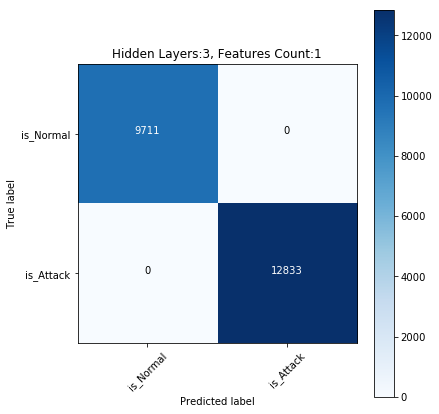

In [15]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

Confusion matrix, without normalization
[[2152    0]
 [   0 9698]]


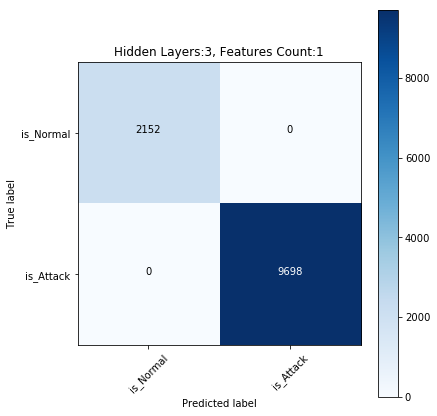

In [16]:
plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)

In [17]:
#4.5 GB
pd.Series(Train.pred_value).to_csv('LSTM_prediction_values-.csv')

In [18]:
past_scores

epoch  train_score  test_score  test_score_20  \
no_of_features hidden_layers                                                  
1              1                  6     1.000000    0.894074       0.798481   
               1                 12     1.000000    0.899264       0.808354   
               1                 18     1.000000    0.899485       0.808776   
               3                  6     1.000000    0.998714       0.997553   
               5                  6     0.969444    0.785708       0.593924   
               1                  6     1.000000    0.894074       0.798481   
               1                 12     1.000000    0.899264       0.808354   
               1                 18     1.000000    0.899485       0.808776   
               3                  6     1.000000    0.998714       0.997553   
               5                  6     0.969444    0.785708       0.593924   
               1                  6     0.999603    0.882230       0.775949   
               1                 12     1.000000    0.890348       0.791392   
               3                  6     1.000000    1.000000       1.000000   
               5                  6     0.976984    0.757275       0.540084   
               5                 12     0.978571    0.758472       0.543038   
               5                 18     0.983730    0.763219       0.550127   
               1                  6     0.999603    0.898643       0.807848   
...                             ...          ...         ...            ...   
               5                 18     0.999603    0.967087       0.937384   
               1                  6     1.000000    0.865596       0.744304   
               1                 12     1.000000    0.897933       0.805823   
               3                  6     1.000000    0.982168       0.966076   
               5                  6     0.997619    0.955199       0.915865   
               5                 12     0.999603    0.978265       0.958650   
               1                  6     1.000000    0.900994       0.811646   
               3                  6     1.000000    0.997028       0.994346   
               3                 12     1.000000    1.000000       1.000000   
               5                  6     0.980952    0.772179       0.567848   
               5                 12     0.982540    0.802165       0.625316   
               1                  6     0.998810    0.886888       0.785148   
               1                 12     0.998413    0.887864       0.787004   
               3                  6     0.996429    0.968506       0.941181   
               5                  6     0.969841    0.818045       0.655696   
               5                 12     0.983730    0.918027       0.846582   
               5                 18     1.000000    0.964292       0.932068   

                              time_taken  
no_of_features hidden_layers              
1              1                5.780286  
               1               11.488336  
               1               14.904817  
               3               12.624567  
               5               10.714801  
               1                5.780286  
               1               11.488336  
               1               14.904817  
               3               12.624567  
               5               10.714801  
               1                5.969323  
               1                8.273357  
               3                6.571577  
               5               24.895278  
               5               48.575404  
               5               58.080909  
               1                6.005653  
...                                  ...  
               5               63.636937  
               1                5.999650  
               1                9.473221  
               3               15.410883  
               5               24.915514  
               5               

In [19]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.mean()

epoch  train_score  test_score  \
no_of_features hidden_layers                                       
1              1              10.560000     0.999730    0.892367   
               3               7.285714     0.999490    0.993172   
               5               9.913043     0.985404    0.864464   

                              test_score_20  time_taken  
no_of_features hidden_layers                             
1              1                   0.795325    8.895777  
               3                   0.987089   14.476304  
               5                   0.743409   35.142935

In [20]:
pgb.std()

epoch  train_score  test_score  \
no_of_features hidden_layers                                      
1              1              4.673329     0.000509    0.009179   
               3              2.554892     0.001148    0.009564   
               5              4.284359     0.012963    0.082740   

                              test_score_20  time_taken  
no_of_features hidden_layers                             
1              1                   0.017505    3.599225  
               3                   0.017979    4.153131  
               5                   0.156682   18.024586